<a href="https://colab.research.google.com/github/parthivz/Fundamentals-of-GenAI-Course-Lab/blob/main/PyTorch_5_Exercise_nnSequential_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classify the concentric circles dataset using a not-so-deep neural network with non-linear activations

The following has your usual imports along with the data generation `circle` and data visualization `decision_boundary` functions predefined for you. You'll start by learning about `circle` and progress to learning about `decision_boundary` later, towards the end of the notebook.

In [20]:
import torch as pt
from torch import nn
import matplotlib.pyplot as plt
import math
%matplotlib inline
pt.manual_seed(1337);

def circle(points = 100, radius_lower = 9., radius_upper = 10.):
  radius = pt.zeros(points).uniform_(radius_lower, radius_upper)
  angle = pt.zeros(points).uniform_(0, 2 * math.pi)

  x = radius * pt.sin(angle)
  y = radius * pt.cos(angle)

  return x,y

def decision_boundary(forward_fn, x_min=-15, x_max=15, y_min=-15, y_max=15, step=0.25):
    import numpy as np
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))

    Xg = np.hstack((xx.ravel()[:, None], yy.ravel()[:, None]))

    X_test = pt.from_numpy(Xg).to(pt.float)
    y_test = forward_fn(X_test).argmax(dim=1).detach().numpy()

    Z = -1 * y_test.reshape(xx.shape)

    fig = plt.figure()
    plt.axis("equal")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.4);
    num_points = X.shape[0] // 2  # Corrected from NUM
    plt.scatter(X[:num_points, 0], X[:num_points, 1], color='orange');
    plt.scatter(X[num_points:, 0], X[num_points:, 1])


## Generate a tuple of tensors for the `x` and `y` coordinates of the inner circle consisting of `100` data points by using the `circle` function.

For example, if you use

<code>
  circle(100, radius_lower = 6., radius_upper=9.)
</code>

The function is going to return a tuple with two tensors, each with a shape of `torch.Size([100])`

In [21]:
inner_x, inner_y = circle(100, radius_lower=6., radius_upper=9.)


## Figure out how to concatenate the `x` and `y` coordinates from the `circle` method into a single tensor

The concatenated tensor should have a of shape `torch.Size([100, 2])`

In [22]:
inner_circle = pt.stack([inner_x, inner_y], dim=1)
inner_circle.shape  # should be torch.Size([100, 2])


torch.Size([100, 2])

## Do the same for the other circle

For example, you can use

<code>
    circle(100, radius_lower = 13., radius_upper=14.)
</code>

to generate an outer circle.

Don't forget to create a `torch.Size([100, 2])` tensor for the outer circle.

In [23]:
outer_x, outer_y = circle(100, radius_lower=13., radius_upper=14.)


## Package the values for the circles into a single `X` tensor to use for training.

Assuming that you used 100 data points per circle, you should end up with an `X` tensor shaped `torch.Size([200, 2])`

In [24]:
outer_circle = pt.stack([outer_x, outer_y], dim=1)
outer_circle.shape  # should be torch.Size([100, 2])


torch.Size([100, 2])

Plot the circles using `scatter`.

* **hint:** recall that you can use the `axis("equal")` method to make the x and y axes equal

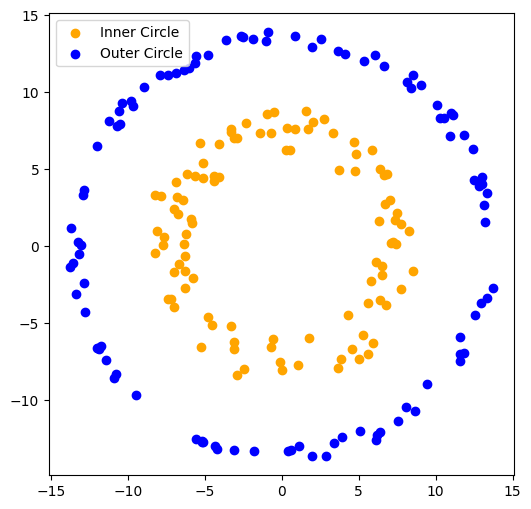

In [25]:
outer_circle = pt.stack([outer_x, outer_y], dim=1)
outer_circle.shape  # should be torch.Size([100, 2])

X = pt.cat([inner_circle, outer_circle])
X.shape  # should be torch.Size([200, 2])

plt.figure(figsize=(6,6))
plt.axis("equal")
plt.scatter(X[:100, 0], X[:100, 1], color="orange", label="Inner Circle")
plt.scatter(X[100:, 0], X[100:, 1], color="blue", label="Outer Circle")
plt.legend()
plt.show()


## Generate the `y` tensor with the classes for each of the circles.

PyTorch loss function does not use one-hot encoding and instead relies on ordinal encoding, where each integer represents a different class. For example, one of your circles would be `0`, another circle `1`, next `2`, and so one.

In this example you only have 2 circles, so use `0` for one of the circles and `1` for another. Your `y` tensor should have a shape of `torch.Size([200])`

In [26]:
y = pt.cat([pt.zeros(100, dtype=pt.long), pt.ones(100, dtype=pt.long)])
y.shape  # should be torch.Size([200])


torch.Size([200])

## Create a neural net using `nn.Sequential`.

It should have a single hidden layer with 3 neurons. All `nn.Linear` layers should use `nn.ReLU` activation function.The output layer should have `nn.LogSoftmax` after the activation function.

Don't forget that softmax assumes one-hot encoding for the outputs!

In [27]:
model = nn.Sequential(
    nn.Linear(2, 3),  # Input layer (2 features) -> Hidden layer (3 neurons)
    nn.ReLU(),
    nn.Linear(3, 2),  # Hidden layer (3 neurons) -> Output layer (2 classes)
    nn.LogSoftmax(dim=1)  # LogSoftmax for classification
)


## Implement the `forward` function.

If your `nn.Sequential` is named `model`, then the forward pass can be as simple as returning `model(X)`.

In [28]:
def forward(X):
    return model(X)


## Complete the implementation of the cross entropy loss

If you used `nn.LogSoftmax` as the output layer of your model, you can use the negative log likelihood loss on the output of the softmax layer from `nn.functional.nll_loss`.

In [29]:
loss_fn = nn.NLLLoss()


## Implement a `metric` method that computes the prediction accuracy

The accuracy should be on a scale from `0.0` to `1.0`

In [30]:
def accuracy(predictions, labels):
    pred_labels = predictions.argmax(dim=1)
    return (pred_labels == labels).float().mean().item()


## Create an instance of the `optim.AdamW` optimizer

* **hint:** if you used `model` as the name of your instance of `nn.Sequential`, then `model.parameters()` can be used to create the optimizer

In [31]:
optimizer = pt.optim.AdamW(model.parameters(), lr=0.01)


## Use the optimizer to discover the neural net weights for classification

You may need to perform thousands of steps of gradient descent. Don't forget to properly perform the forward and backward passes. If your instance of `AdamW` is named `optimizer`, then you can perform a gradient descent step using `optimizer.step()`. To zero out the gradients in the model, you can use `optimizer.zero_grad()`.

In [32]:
epochs = 3000
for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = forward(X)
    loss = loss_fn(y_pred, y)

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        acc = accuracy(y_pred, y)
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {acc:.4f}")


Epoch 0: Loss = 1.2098, Accuracy = 0.5000
Epoch 500: Loss = 0.1127, Accuracy = 0.9950
Epoch 1000: Loss = 0.0576, Accuracy = 1.0000
Epoch 1500: Loss = 0.0359, Accuracy = 1.0000
Epoch 2000: Loss = 0.0250, Accuracy = 1.0000
Epoch 2500: Loss = 0.0186, Accuracy = 1.0000


The `decision_boundary` function declared previously in this notebook uses a grid of test data points to draw the decision boundary for your model. The grid is like a grid on graph paper, so that for every point on the grid, you are going to use the `forward` method of your model to find out the predicted values for the points and color the grid accordingly.

The `no_grad` function disables gradient calculations when performing the `forward`.



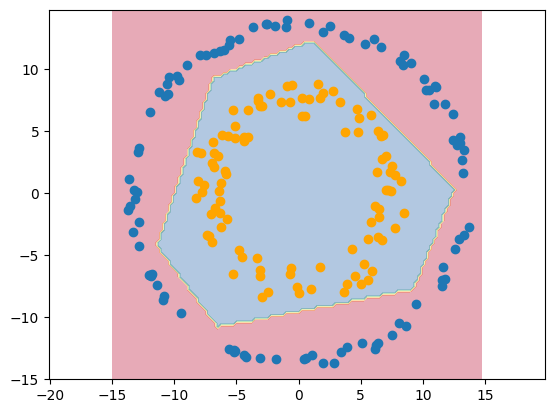

In [33]:
with pt.no_grad():
  decision_boundary(forward)

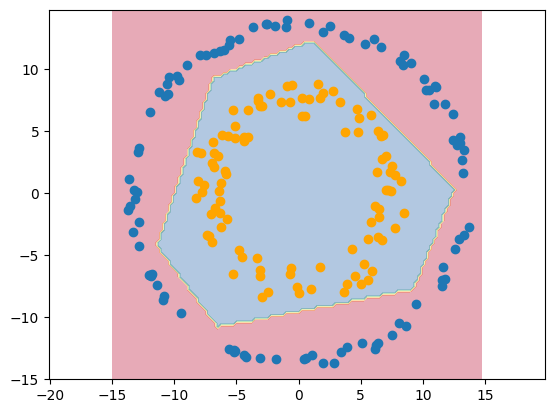

In [34]:
with pt.no_grad():
    decision_boundary(forward)
